In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from pylab import rcParams
import re
import time
from datetime import datetime
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv("readings-2026-02-25-16.00.csv", on_bad_lines='error')
display(df.shape, df.sample(10))

(5000, 5)

,cpu_speed,volts,cpu_pct,load_avg,temp
4806,2.400034,0.8898,4.7,0.962891,47.2
861,2.400034,0.8898,26.2,2.333496,51.0
2762,2.400034,0.8898,50.5,3.158691,53.2
4147,1.800019,0.8898,17.1,1.579590,48.3
4756,1.500023,0.8898,3.8,1.237305,47.2
2738,2.400020,0.8898,41.7,3.346680,53.2
3214,2.400024,0.8898,65.4,2.207031,53.2
4571,1.700021,0.7936,0.9,1.550781,48.3
1586,2.400024,0.8898,26.9,1.950195,49.9
1559,2.400020,0.8898,24.1,1.933594,49.9


<Figure size 640x480 with 0 Axes>

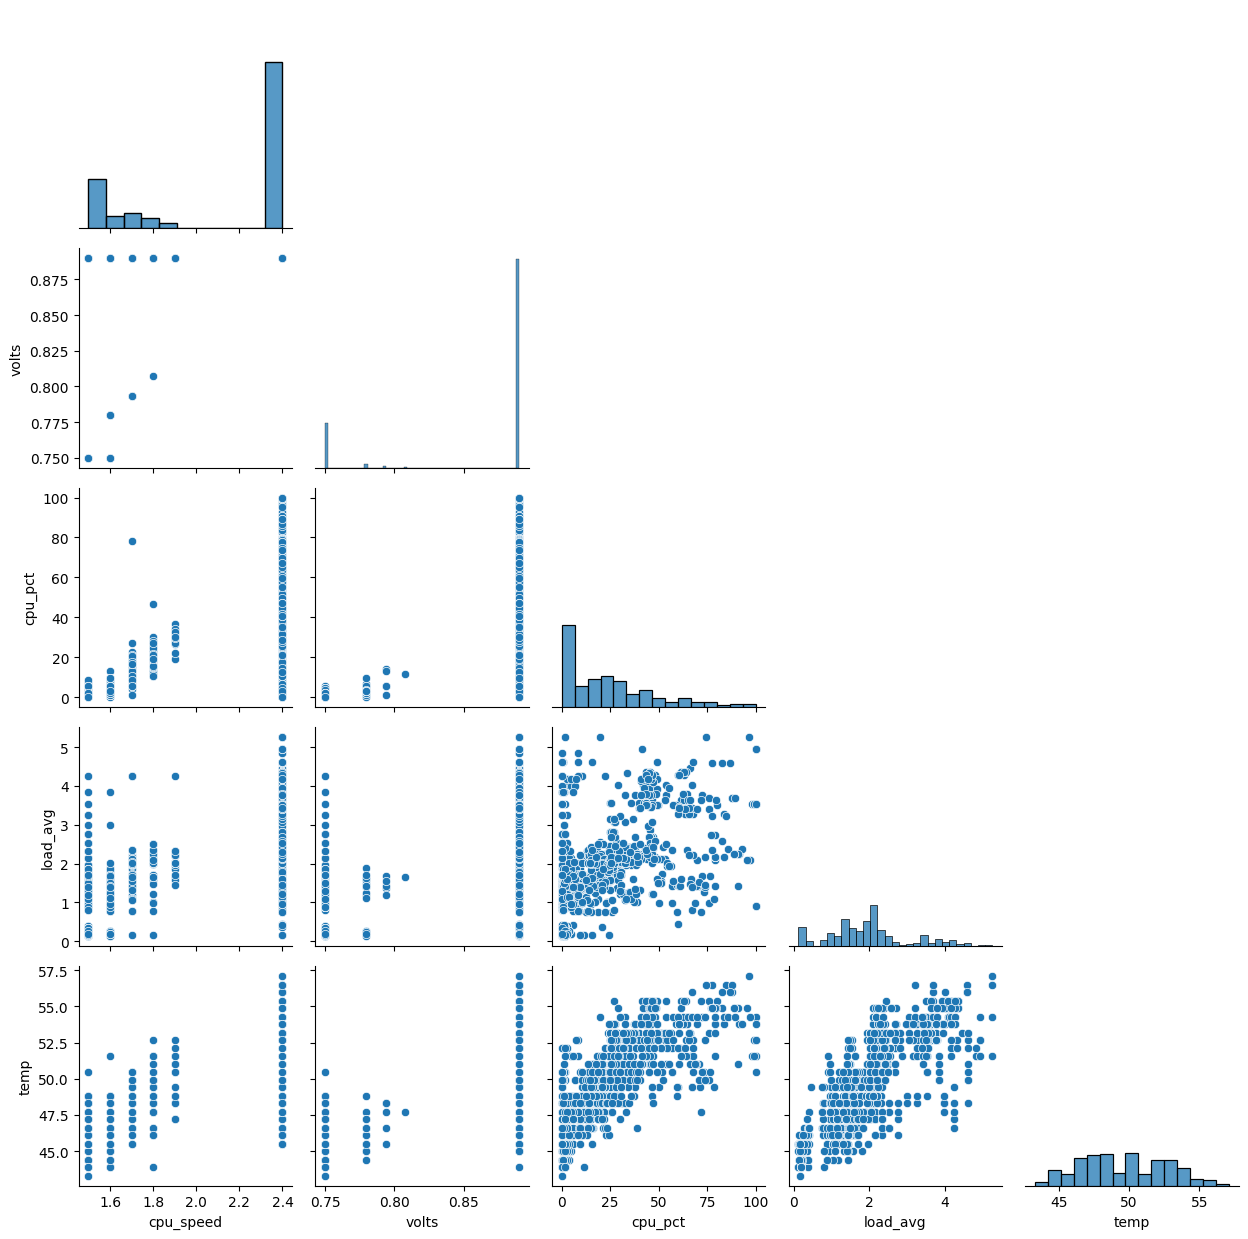

In [3]:
plt.clf()
# scatter_matrix(df.sample(2000), figsize=(10, 8))
sns.pairplot(df.sample(1000), kind="scatter", diag_kind="hist", corner=True)
plt.tight_layout() 
plt.show()

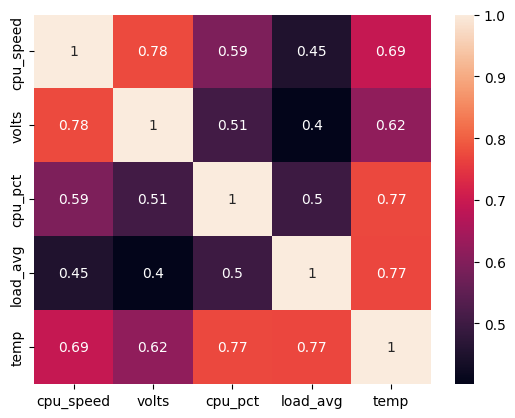

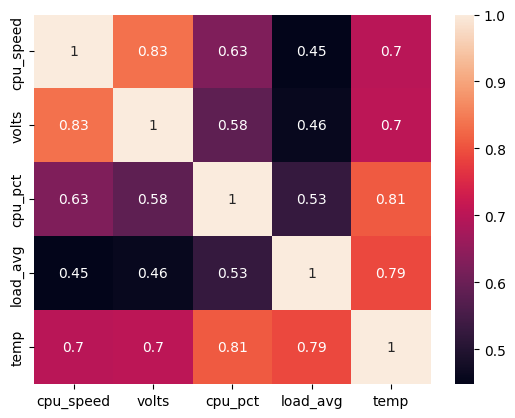

In [4]:
# 5-point rolling average to smooth noise
df_adjusted = df.copy()
rolling_cols = ["volts", "load_avg", "temp", "cpu_pct"]
df_adjusted[rolling_cols] = df_adjusted[rolling_cols].rolling(window=5).mean()

sns.heatmap(df.corr(), annot=True)
plt.show()
sns.heatmap(df_adjusted.corr(), annot=True)
plt.show()

# Basic Linear Regression
Predicting CPU temperature from metrics using linear models.

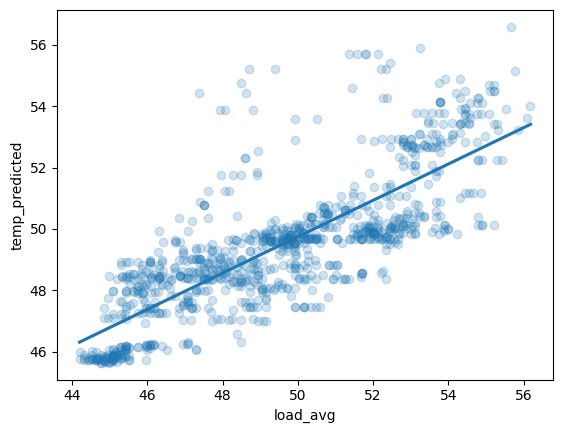

'Model coefficients: [2.32647443]'

'Model intercept: 49.62938938938938'

'Mean squared error: 3.21'

'Coefficient of determination: 0.63'

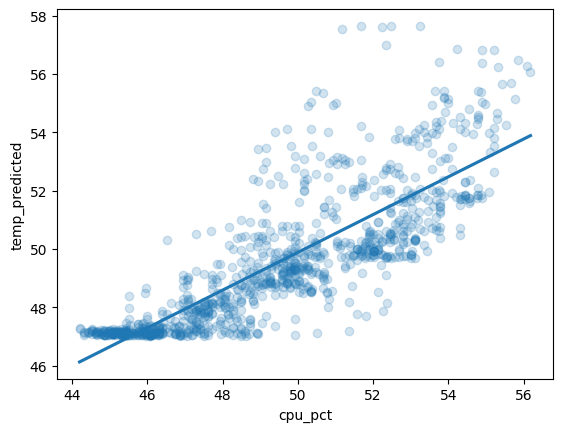

'Model coefficients: [2.37856765]'

'Model intercept: 49.62938938938938'

'Mean squared error: 2.90'

'Coefficient of determination: 0.67'

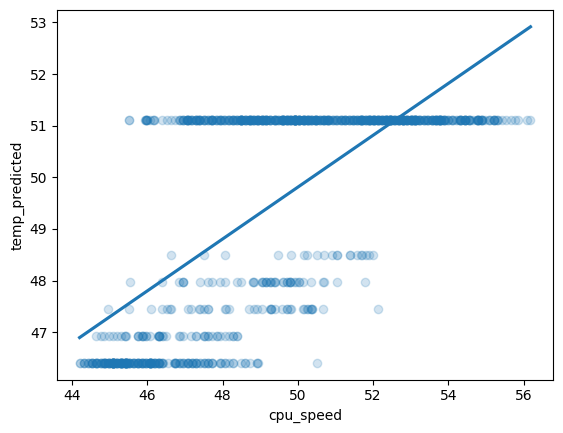

'Model coefficients: [2.05238029]'

'Model intercept: 49.62938938938938'

'Mean squared error: 4.32'

'Coefficient of determination: 0.50'

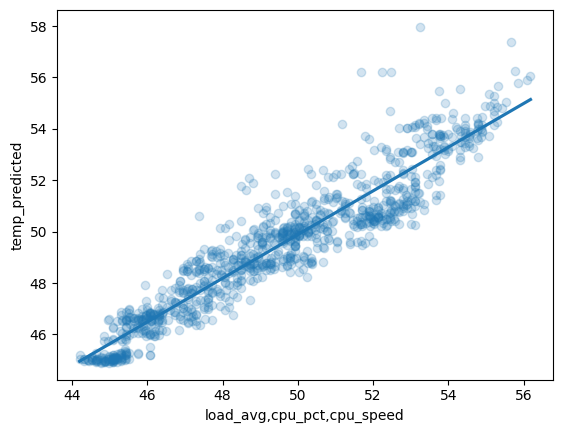

'Model coefficients: [1.37458018 1.23568157 0.66889383]'

'Model intercept: 49.62938938938938'

'Mean squared error: 1.02'

'Coefficient of determination: 0.88'

In [5]:
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Grab the adjusted data, but drop any rows with missing data.
# The rows with missing data were created by the rolling average.
df_data = df_adjusted.dropna(how="any")

# Try it first with each column, then with all. We know from the histograms
# that fan speed and volts are not good predictors.
linreg_feature_cols = ["load_avg", "cpu_pct", "cpu_speed"]
for fc in [[x] for x in linreg_feature_cols] + [linreg_feature_cols]:

    # Separate the feature data from the target data we want to predict.
    X = df_data[fc]
    y = df_data.temp

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

    plt.clf()

    linreg = make_pipeline(StandardScaler(), 
                           LinearRegression()) 
    linreg.fit(X_train,y_train)
    y_pred = linreg.predict(X_test)

    sns.regplot(x=y_test, y=y_pred, ci=None, scatter_kws={'alpha':0.2})
    plt.xlabel(",".join(fc))
    plt.ylabel('temp_predicted')
    plt.show()

    # Show some model stats
    regression_model = linreg.named_steps['linearregression']
    display(f"Model coefficients: {regression_model.coef_}")
    display(f"Model intercept: {regression_model.intercept_}")

    # We want a low mean squared error and a coefficient of determination (R^2) as close to 1 as possible.
    display(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
    display(f"Coefficient of determination: {r2_score(y_test, y_pred):.2f}")

# Basic Logistic Regression

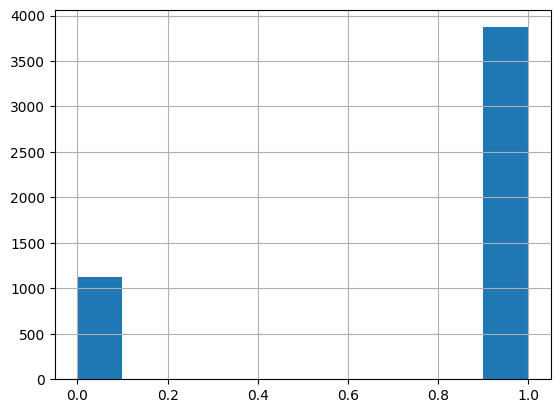

,cpu_speed,volts,cpu_pct,load_avg,temp,voltage_level
cpu_speed,1.000000,0.834717,0.625576,0.447875,0.699398,0.796148
volts,0.834717,1.000000,0.583318,0.458857,0.704087,0.962035
cpu_pct,0.625576,0.583318,1.000000,0.527273,0.809273,0.555647
load_avg,0.447875,0.458857,0.527273,1.000000,0.790701,0.441622
temp,0.699398,0.704087,0.809273,0.790701,1.000000,0.671619
voltage_level,0.796148,0.962035,0.555647,0.441622,0.671619,1.000000


'Train length: 3996, Test length: 1000'

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       241
           1       0.98      0.96      0.97       759

    accuracy                           0.95      1000
   macro avg       0.93      0.94      0.94      1000
weighted avg       0.95      0.95      0.95      1000



array([[224,  17],
       [ 31, 728]])

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

df_data = df_adjusted.copy().dropna(how="any")

# Convert cpu voltage into a low/high indicator.
df_data["voltage_level"] = df_data.volts.apply(lambda x: 1 if x >= .825 else 0)
plt.clf()
df_data.voltage_level.hist()
plt.show()

display(df_data.corr())

logreg_feature_cols = ["temp", "cpu_speed"]

X = df_data[logreg_feature_cols].values
y = df_data.voltage_level.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
display(f"Train length: {len(X_train)}, Test length: {len(X_test)}")

logreg = make_pipeline(StandardScaler(), 
                       LogisticRegression()) 
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(metrics.classification_report(y_test, y_pred))
display(metrics.confusion_matrix(y_test, y_pred))

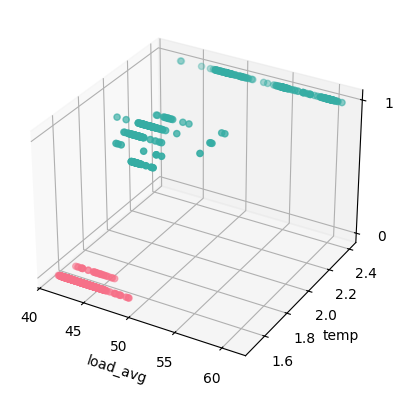

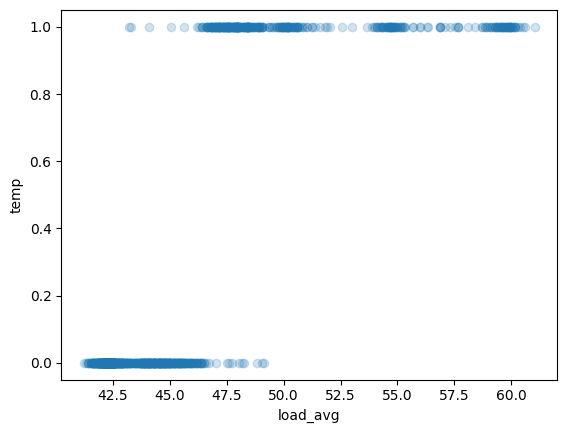

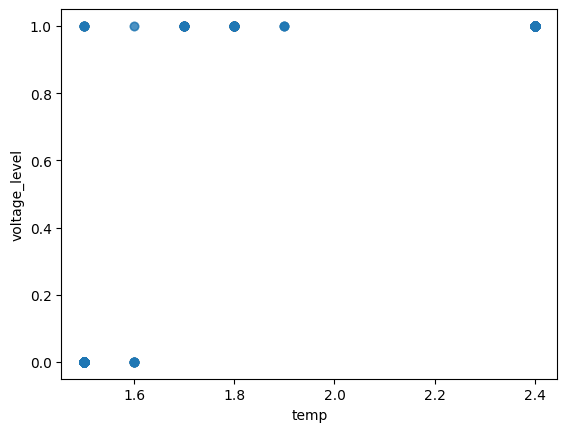

In [28]:
from matplotlib.colors import ListedColormap

plt.clf()

ax = plt.axes(projection = '3d')

x = np.array(X_test).T[0]
y = np.array(X_test).T[1]
z = y_pred

ax.set_xlabel("load_avg")
ax.set_ylabel("temp")
ax.set_zlabel("voltage_level")
ax.set_zticks([0,1])

cmap = ListedColormap(sns.color_palette("husl", 2).as_hex())
ax.scatter(x, y, z, c=z, cmap=cmap)

plt.show()

plt.clf()
ax = plt.axes()
ax.scatter(np.array(X_test).T[0], y_pred, alpha=0.2)
plt.xlabel('load_avg')
plt.ylabel('temp')
plt.show()

plt.clf()
ax = plt.axes()
ax.scatter(np.array(X_test).T[1], y_pred, alpha=0.2)
plt.xlabel('temp')
plt.ylabel('voltage_level')
plt.show()


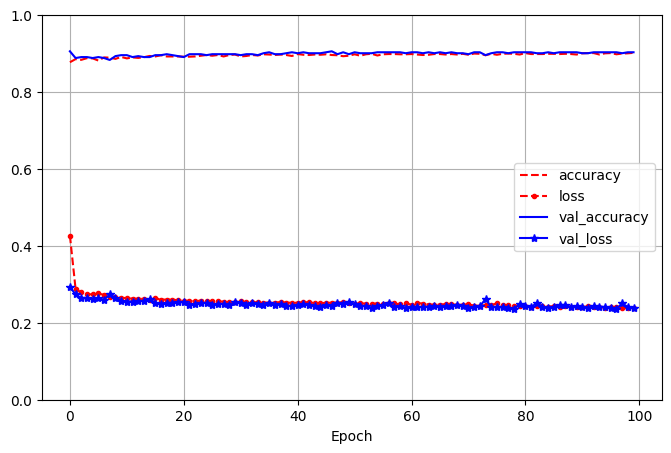

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9160 - loss: 0.2260 


[0.24077677726745605, 0.906000018119812]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


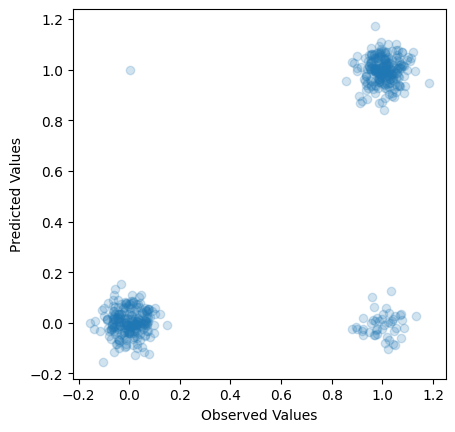

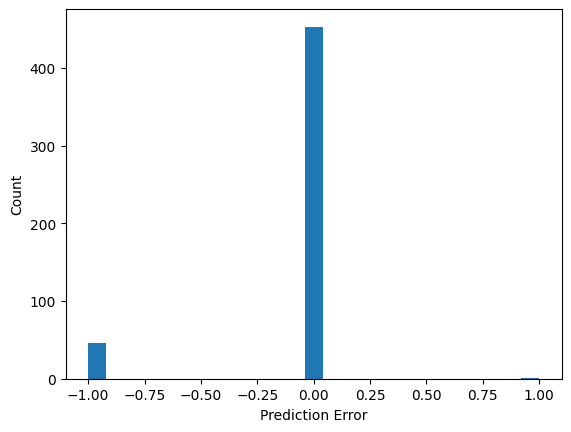